# Dreambooth Training using Hugging Face Diffusers

## Clone Diffusers GitHub Repository


In [1]:
import os

if not os.path.exists('diffusers'):
    !git clone https://github.com/huggingface/diffusers

Cloning into 'diffusers'...
remote: Enumerating objects: 55211, done.
remote: Counting objects: 100% (13697/13697), done.
remote: Compressing objects: 100% (1383/1383), done.
remote: Total 55211 (delta 13137), reused 12401 (delta 12284), pack-reused 41514
Receiving objects: 100% (55211/55211), 36.79 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (40348/40348), done.


## Install Diffusers and Other Requirements

In [2]:
!pip install transformers==4.30.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 30.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 774.0/774.0 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.7 MB/s eta 0:00:0000:0100:01


In [3]:
%cd diffusers
!pip install -q .

/workspace/diffusers


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
%cd examples/dreambooth/
!pip install -q -r requirements.txt

/workspace/diffusers/examples/dreambooth


In [5]:
seed = 42

## Setup Accelerate with Basic Configuration

In [6]:
from accelerate.utils import write_basic_config

write_basic_config()

PosixPath('/root/.cache/huggingface/accelerate/default_config.yaml')

## Download Data

In [7]:
import requests
import zipfile

# To download and unzip processed dataset.
def download_and_unzip(url, save_path):

    print("Downloading and extracting assets...", end="")
    file = requests.get(url)
    open(save_path, "wb").write(file.content)

    try:
        with zipfile.ZipFile(save_path) as z:
            z.extractall(os.path.split(save_path)[0]) # Unzip where downloaded.
            print("Done")
    except:
        print("Invalid file")

URL = r"https://www.dropbox.com/scl/fi/m8xvx5rm8xzoiw1uzutk6/tonkinese_cat.zip?rlkey=1r8zmgvnbuy41hl185ev6v7ji&dl=1"

dataset_name = "tonkinese_cat"
dataset_zip_path = os.path.join(os.getcwd(), f"{dataset_name}.zip")
dataset_path = os.path.join(os.getcwd(), dataset_name)

# Download if dataset does not exists.
if not os.path.exists(dataset_path):
    download_and_unzip(URL, dataset_zip_path)
    # shutil.rmtree(dataset_zip_path) # Remove the ZIP file to free storage space.

## Training

In [8]:
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5"  \
  --instance_data_dir="tonkinese_cat" \
  --output_dir="outputs" \
  --instance_prompt="a photo of sks tonkinese cat" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=500 \
  --mixed_precision="fp16" \
  --checkpointing_steps=50000

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
02/26/2024 05:09:09 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

tokenizer/tokenizer_config.json: 100%|█████████| 806/806 [00:00<00:00, 4.41MB/s]
tokenizer/vocab.json: 100%|████████████████| 1.06M/1.06M [00:00<00:00, 1.59MB/s]
tokenizer/merges.txt: 100%|██████████████████| 525k/525k [00:00<00:00, 1.59MB/s]
text_encoder/config.json: 100%|████████████████| 617/617 [00:00<00:00, 4.22MB/s]
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
scheduler/scheduler_config.json: 100%|█████████| 308/308 [00:00<00:00, 2.38MB/s]
{'dynamic_thresholding_ratio', 'variance_type', 'timestep_spacing', 'prediction_ty

## Inference

In [9]:
from diffusers import StableDiffusionPipeline

import torch

In [10]:
seed = 42

In [11]:
pipe = StableDiffusionPipeline.from_pretrained(
    'outputs',
    torch_dtype=torch.float16,
).to('cuda')

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/models/lora.py:384: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)
/opt/conda/lib/python3.10/site-packages/diffusers/models/lora.py:300: FutureWarning: `LoRACompatibleConv` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleConv` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleConv", "1.0.0", deprecation_message)


  0%|          | 0/150 [00:00<?, ?it/s]

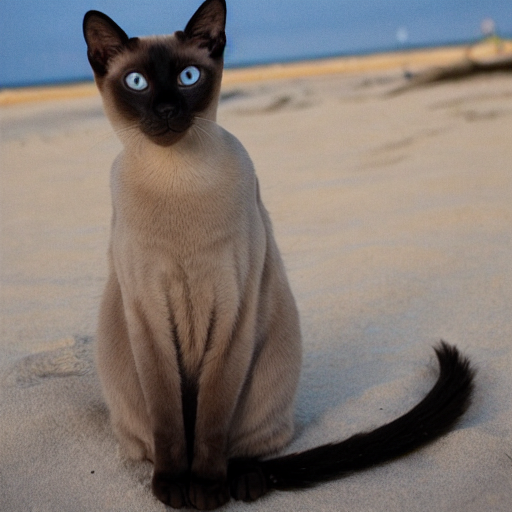

In [12]:
prompt = "a photo of sks tonkinese cat, sitting on a beach, sunset time, highly detailed, 4k"
image = pipe(prompt, num_inference_steps=150, generator=torch.manual_seed(seed)).images[0]

image

  0%|          | 0/150 [00:00<?, ?it/s]

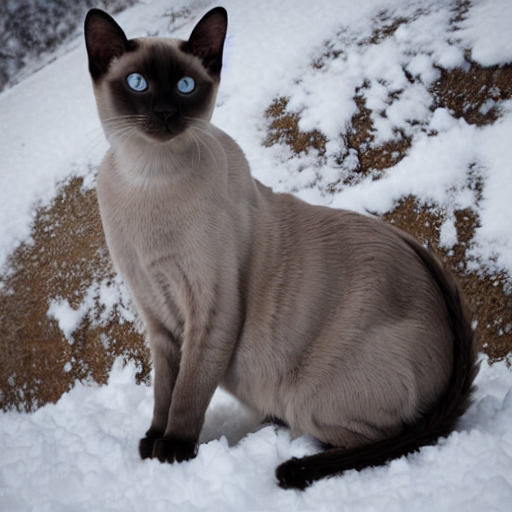

In [13]:
prompt = "a photo of sks tonkinese cat, on a snowy mountain, highly detailed"
image = pipe(prompt, num_inference_steps=150, generator=torch.manual_seed(seed)).images[0]

image

  0%|          | 0/150 [00:00<?, ?it/s]

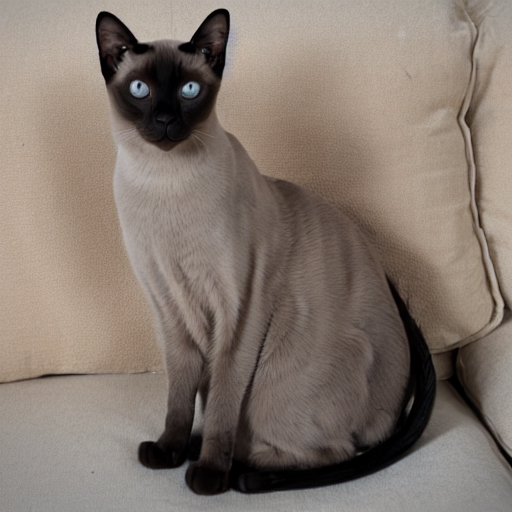

In [14]:
prompt = "a photo of sks tonkinese cat, sitting a couch"
image = pipe(prompt, num_inference_steps=150, generator=torch.manual_seed(seed)).images[0]

image

  0%|          | 0/150 [00:00<?, ?it/s]

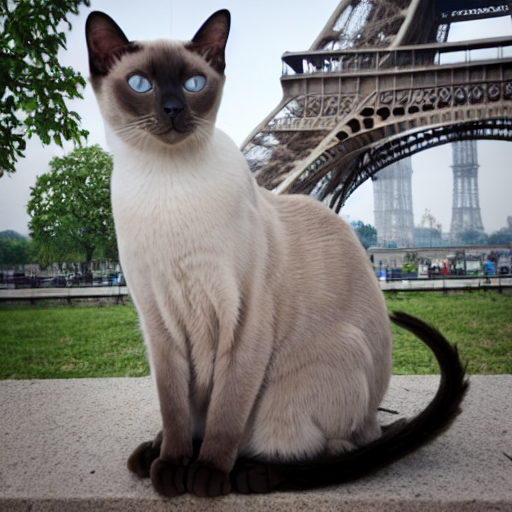

In [15]:
prompt = "a photo of sks tonkinese cat, in front of the eiffel tower"
image = pipe(prompt, num_inference_steps=150, generator=torch.manual_seed(seed)).images[0]

image

  0%|          | 0/150 [00:00<?, ?it/s]

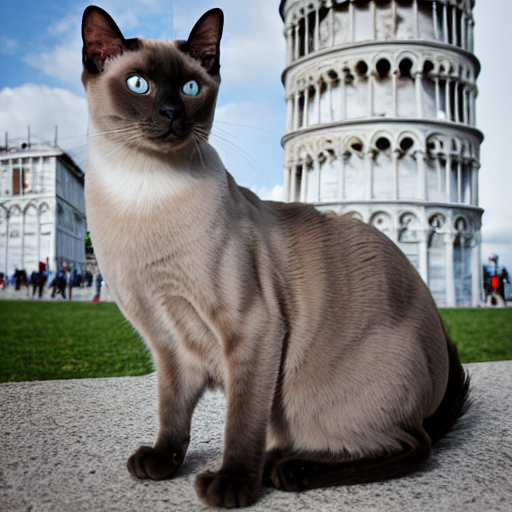

In [16]:
prompt = "a photo of sks tonkinese cat, walking in front of the leaning tower of pisa"
image = pipe(prompt, num_inference_steps=150, generator=torch.manual_seed(seed)).images[0]

image

  0%|          | 0/150 [00:00<?, ?it/s]

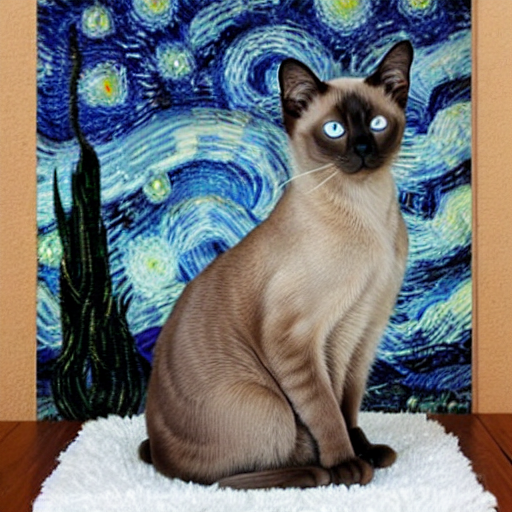

In [17]:
prompt = "a photo of sks tonkinese cat with the starry night painting in the background"
image = pipe(
    prompt, 
    num_inference_steps=150,
    generator=torch.manual_seed(seed)
).images[0]

image